In [109]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

In [33]:
# Откроем все таблицы из папки data в соответствующие датафреймы
df_category_spends = pd.read_csv('data/category_wise_spends.csv')
df_race_spends = pd.read_csv('data/race_wise_spends.csv')
df_team = pd.read_csv('data/team_info.csv')
df_races = pd.read_csv('data/races_updated.csv')
df_sprint = pd.read_csv('data/sprint_results_updated.csv')
df_results = pd.read_csv('data/results_updated.csv')
df_qualifying = pd.read_csv('data/qualifying_updated.csv')
df_pit = pd.read_csv('data/pit_stops_updated.csv')
df_lap = pd.read_csv('data/lap_times_updated.csv')
df_drivers = pd.read_csv('data/drivers_updated.csv')
df_driver_standings = pd.read_csv('data/driver_standings_updated.csv')
df_constructor_standings = pd.read_csv('data/constructor_standings_updated.csv')
df_constructor_results = pd.read_csv('data/constructor_results_updated.csv')
df_constructors = pd.read_csv('data/constructors_updated.csv')

# Преображение данных


Для начала проведем некоторые манипуляции для интеграции таблиц с сайта f1budgetcup.com с таблицами с kaggle.com

"Соединим" таблицу race_spends по raceId с каггловскими датасетами

In [34]:
# Удалим скобки и года из столбца 'title'
df_race_spends['title'] = df_race_spends['title'].apply(lambda x: re.sub(r'\s*\[.*?\]\s*', '', x))

# Проведем слияние таблиц по колонкам 'title' и 'year'
merged_df = pd.merge(df_race_spends, df_races, left_on=['title', 'year'], right_on=['name', 'year'], how='left')

# Результат слияния, включая новый raceId
df_race_spends = merged_df[['id', 'title', 'sum', 'team_id', 'year', 'raceId']]
df_race_spends

,id,title,sum,team_id,year,raceId
0,19,Japanese Grand Prix,385417,1,2022,1092.0
1,21,Mexico Grand Prix,385417,1,2022,NaN
2,25,Dhabi Grand Prix,385417,1,2022,NaN
3,8,Monaco Grand Prix,385417,1,2022,1080.0
4,17,Italian Grand Prix,770834,1,2022,1089.0
...,...,...,...,...,...,...
403,15,Belgian Grand Prix,683000,10,2023,1110.0
404,20,Qatar Grand Prix,665000,10,2023,1115.0
405,9,Spanish Grand Prix,665000,10,2023,1105.0
406,22,United States Grand Prix,665000,10,2023,1116.0


Заметим, что raceId в некоторых строках отсутствует. Скорее всего это произошло из-за некачественного датасета с сайта f1budgetcup.com, в котором хранились данные по гран-при, которые не проводились в определенные сезоны.

In [69]:
# Удалим отсутствующие данные Nan из столбца 'raceId'
df_race_spends = df_race_spends.dropna(subset=['raceId'])

# Заменим возможные NaN значения в столбце 'raceId' на -1 и переведем значения столбца 'raceId' в integer
df_race_spends['raceId'] = df_race_spends['raceId'].fillna(-1).astype(int)

## Обновим Id команд в таблицах с сайта f1budgetcup.com по датасетам из каггла

In [36]:
# Создадим словарь с именами команд из team_info, которые нужно преобразовать в имена команд из constructors 
rename_dict = {
    'Visa Cash App RB F1 Team': 'AlphaTauri',
    'Red Bull': 'Red Bull',
    'Williams': 'Williams',
    'Stake F1 Team Kick Sauber': 'Sauber',
    'Mc Laren': 'McLaren',
    'Mercedes': 'Mercedes',
    'Haas F1 Team': 'Haas F1 Team',
    'Ferrari': 'Ferrari',
    'Alpine': 'Alpine F1 Team'
}

# Переименуем строки в столбце 'team_name' с использованием словаря
df_team['team_name'] = df_team['team_name'].replace(rename_dict)

# Переименуем столбец team_name в name для удобства
df_team = df_team.rename(columns={'team_name': 'name'})

# Используем объединение по столбцу 'name'
df_team = df_team.merge(df_constructors[['name', 'constructorId']], on='name', how='left')

In [37]:
# Объединим оставшиеся таблицы с сайта f1budgetcup.com по столбцу 'team_id'
df_category_spends = df_category_spends.merge(df_team[['team_id', 'constructorId']], on='team_id', how='left')
df_race_spends = df_race_spends.merge(df_team[['team_id', 'constructorId']], on='team_id', how='left')

# Удалим  столбец 'team_id' из всех таблиц
df_category_spends = df_category_spends.drop(columns=['team_id'])
df_race_spends = df_race_spends.drop(columns=['team_id'])
df_team = df_team.drop(columns=['team_id'])

Теперь, когда наши датасеты приведены в порядок, можно приступать к их анализу

## Информация о датасетах

Краткая сводка по информации, содержащейся в датафреймах:

df_category_spends - Годовые расходы команд Формулы 1, распределенные по конкретным категориям затрат.
df_race_spends - Годовые расходы команд Формулы 1 на каждое Гран-при.
df_team - Информация о командах и их общих бюджетах по годам.
df_races - Информация о проведенных гонках за исследуемые годы.
df_sprint - Информация о проведенных спринтах перед Гран-при.
df_results - Результаты гонщиков на каждом Гран-при.
df_qualifying - Результаты квалификаций гонщиков перед Гран-при.
df_pit - Информация о пит-стопах.
df_lap - Информация по каждому кругу на Гран-при.
df_drivers - Список гонщиков Формулы 1.
df_driver_standings - Итоговые результаты гонщиков Формулы 1 по сезонам.
df_constructor_standings - Итоговые результаты команд Формулы 1 по сезонам.
df_constructor_results - Результаты команд на каждом Гран-при.
df_constructors - Список команд Формулы 1.

# Графики

### Трекинг кумулятивных очков по сезонам:

#### График кумулятивных очков по гонкам

###### График кумулятивных очков по гонкам представляет собой линейный график с гонками по оси X и кумулятивными очками по оси Y для всех гонщиков. На графике выделены линии топ-5 гонщиков каждого сезона разными цветами для наглядного отображения их прогресса. Остальные гонщики отображены серым цветом.

In [38]:
# Разделение данных на сезоны
def seasons_separation(df):
    """
    Функция для деления данных на сезоны 2022 и 2023 года.
    """
    season_2022 = df[(df['raceId'] >= 1074) & (df['raceId'] <= 1096)]
    season_2023 = df[(df['raceId'] >= 1098) & (df['raceId'] <= 1120)]
    
    return season_2022, season_2023

In [39]:
def get_top_drivers(df, n):
    """
    Функция для определения топ-n гонщиков по очкам.
    """
    top_drivers = df.groupby('driverId')['points'].max().nlargest(n).index
    return top_drivers

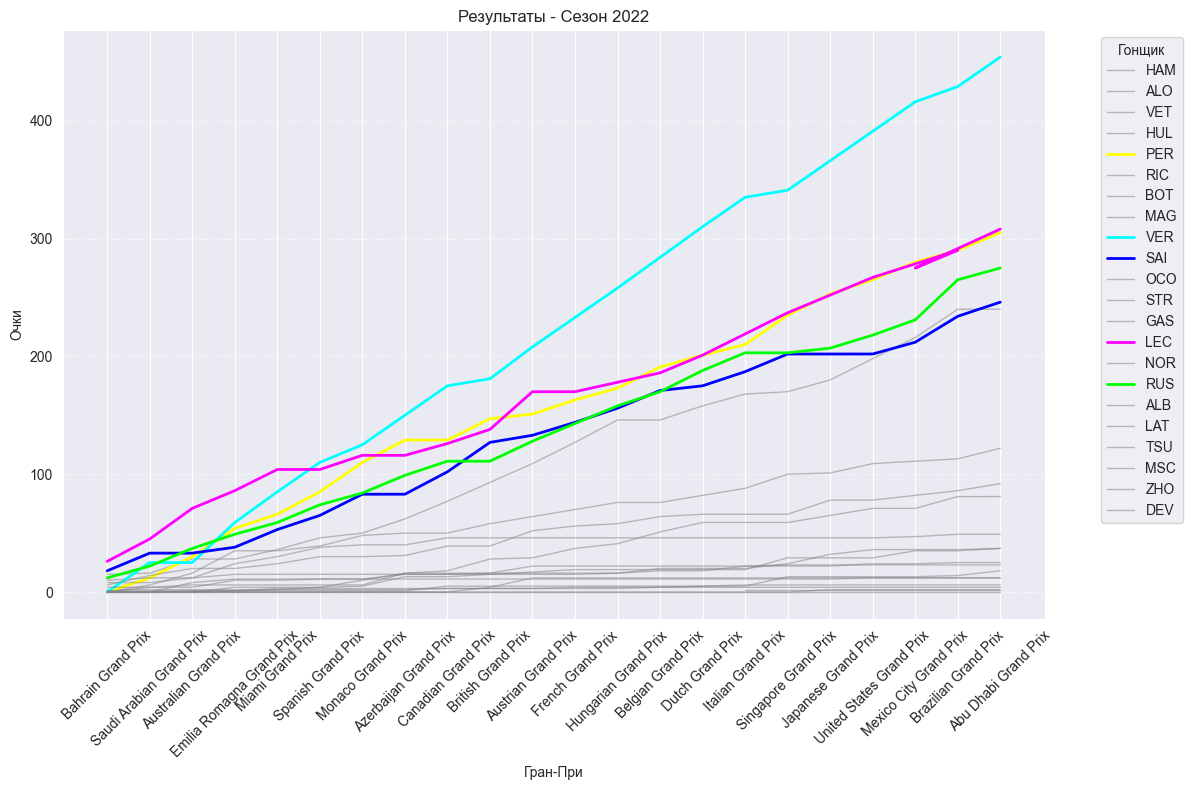

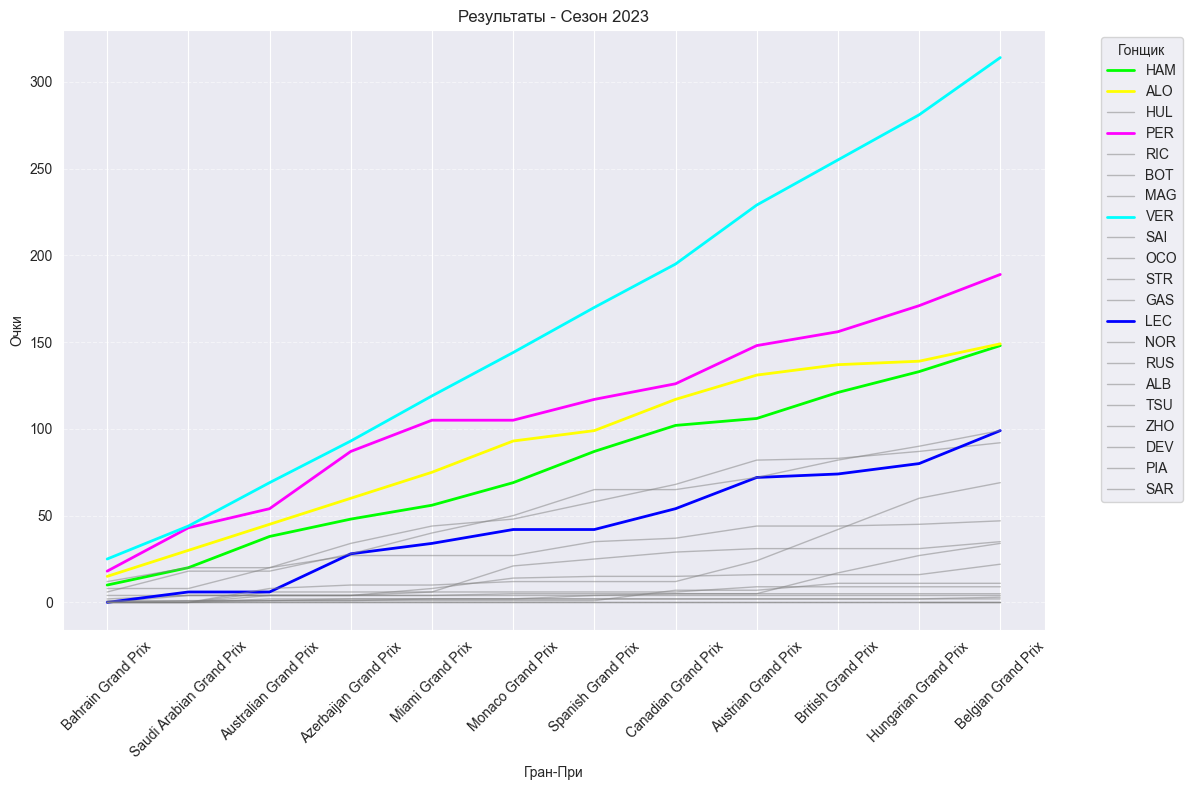

In [40]:
# Объединение данных по raceId и driverId
df_merged = pd.merge(df_driver_standings, df_races[['raceId', 'name']], on='raceId')
df_merged = pd.merge(df_merged, df_drivers[['driverId', 'code']], on='driverId')

def plot_season_data(season_data, title):
    """
    Функция для построения графика топ-5 гонщиков по накопленным очкам в течении сезона.
    """
    plt.figure(figsize=(12, 8))

    # Определяем топ-5 гонщиков
    top_5_drivers = get_top_drivers(season_data, 5)

    colors = ['cyan', 'magenta', 'yellow', 'lime', 'blue']

    for driver_id, driver_data in season_data.groupby('driverId'):
        driver_code = driver_data['code'].iloc[0]
        if driver_id in top_5_drivers:  
            color = colors[list(top_5_drivers).index(driver_id)]
            plt.plot(driver_data['name'], driver_data['points'], label=driver_code, linewidth=2, color=color)
        else:
            plt.plot(driver_data['name'], driver_data['points'], label=driver_code, color='gray', alpha=0.5, linewidth=1)

    plt.title(title)
    plt.xlabel('Гран-При')
    plt.ylabel('Очки')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.legend(title='Гонщик', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Построение графика для сезона 2022
plot_season_data(seasons_separation(df_merged)[0], 'Результаты - Сезон 2022')

# Построение графика для сезона 2023
plot_season_data(seasons_separation(df_merged)[1], 'Результаты - Сезон 2023')

#### Трекинг результатов по гонкам:

###### График финишных позиций по гонкам скаттерплот с гонками по оси X и финишными позициями по оси Y для выбранных водителей.

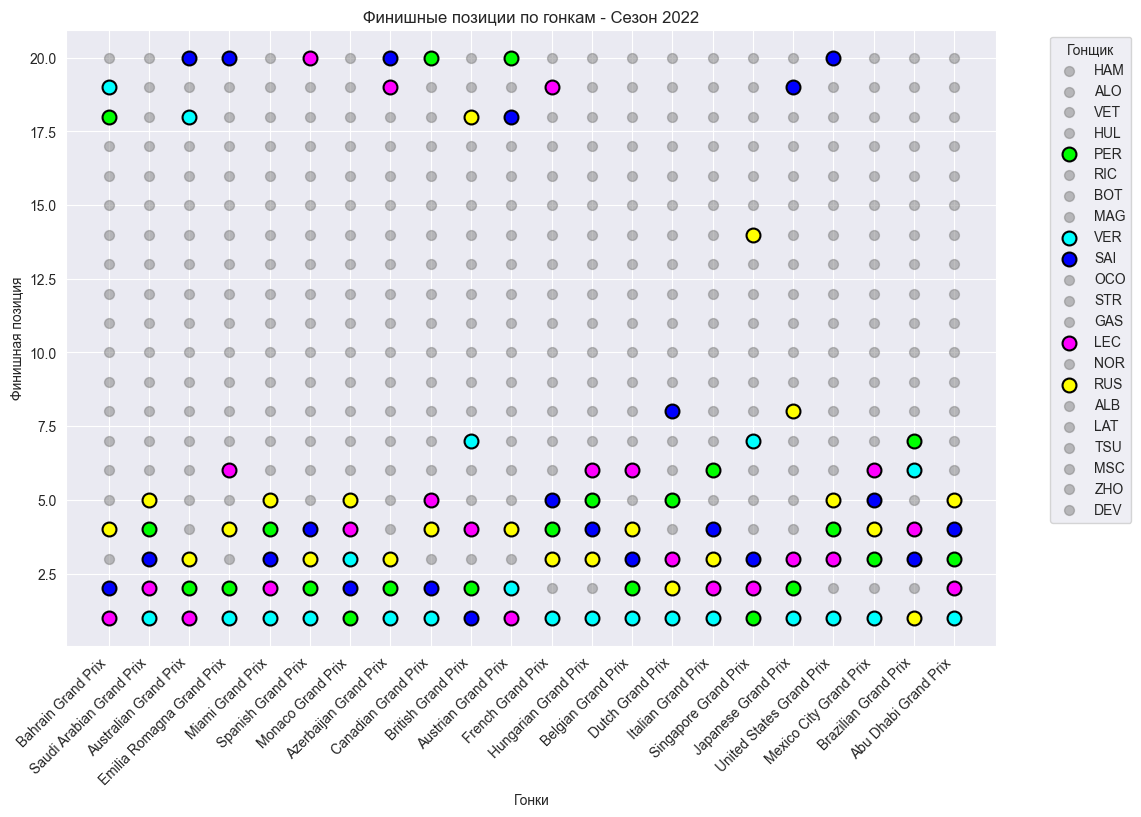

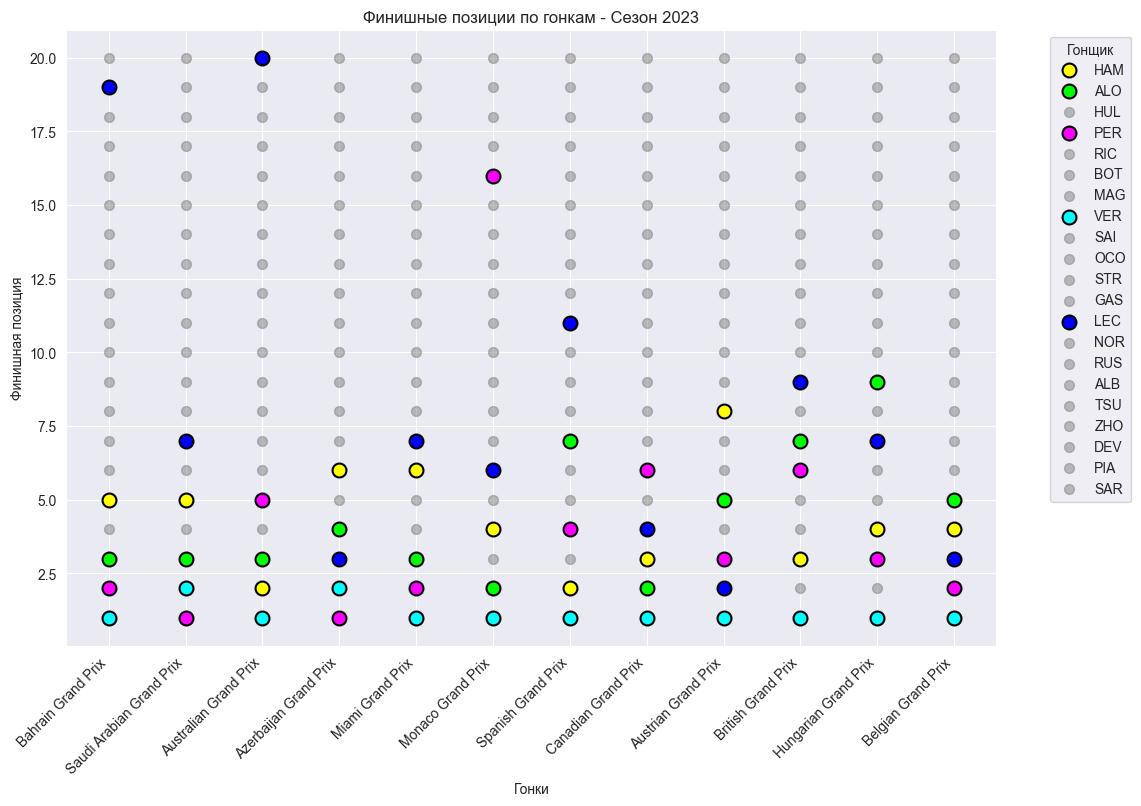

In [41]:
# Объединение df_results с df_drivers по столбцу driverId
df_merged = pd.merge(df_results, df_drivers, on='driverId')

# Сгруппируем данные по гонкам и водителям и проведем расчет средней финишной позиции
avg_finish_positions = df_merged.groupby(['raceId', 'driverId'])['positionOrder'].mean().reset_index()

# Получение названий гонок из df_races
race_names = df_races.set_index('raceId')['name']

def plot_driver_positions(season_data, title):
    """
    Функция для построения графика финишных позиций по гонкам.
    """
    plt.figure(figsize=(12, 8))

    # Определение топ-5 самых быстрых гонщиков
    top_5_drivers = get_top_drivers(season_data, 5)

    # Цвета для топ-5 гонщиков
    colors = ['cyan', 'magenta', 'yellow', 'lime', 'blue']

    # Построим точки для каждого водителя
    for driverId, group in season_data.groupby('driverId'):
        driver_name = df_drivers.loc[df_drivers['driverId'] == driverId, 'code'].values[0]
        race_ids = group['raceId']
        race_labels = race_names[race_ids].tolist()
        if driverId in top_5_drivers:
            color = colors[list(top_5_drivers).index(driverId)]
            plt.scatter(race_labels, group['positionOrder'], label=driver_name, color=color, s=100, edgecolor='black', linewidth=1.5)
        else:
            plt.scatter(race_labels, group['positionOrder'], label=driver_name, color='gray', alpha=0.5, s=50)

    plt.title(title)
    plt.xlabel('Гонки')
    plt.ylabel('Финишная позиция')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Гонщик', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

# Построение графиков для сезонов 2022 и 2023
plot_driver_positions(seasons_separation(df_merged)[0], 'Финишные позиции по гонкам - Сезон 2022')
plot_driver_positions(seasons_separation(df_merged)[1], 'Финишные позиции по гонкам - Сезон 2023')

###### Распределение позиций на старте и на финише. Скаттерплот, где каждая точка показывает стартовую и финишную позицию водителя в каждой гонке. Цветами отмечены лучшие 5 гонщиков.

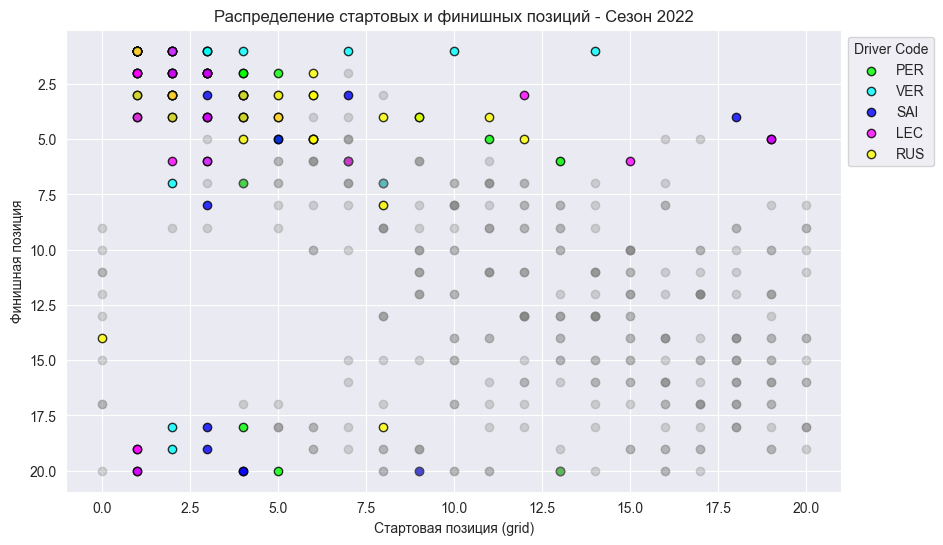

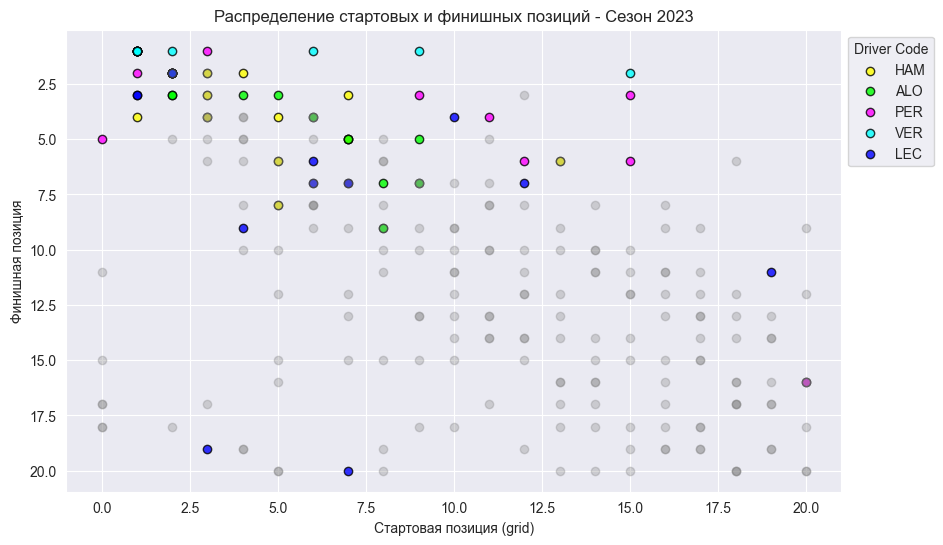

In [42]:
# Объединение df_results с df_drivers по столбцу driverId
df_merged = pd.merge(df_results, df_drivers, on='driverId')
df_merged = pd.merge(df_merged, df_races[['raceId', 'name']], on='raceId')

# Функция для построения графика распределения стартовых и финишных позиций с выделением топ-5 гонщиков
def plot_start_vs_finish(season_data, title):
    top_5_drivers = get_top_drivers(season_data, 5)
    colors = ['cyan', 'magenta', 'yellow', 'lime', 'blue']
    
    plt.figure(figsize=(10, 6))
    
    for driverId, group in season_data.groupby('driverId'):
        driver_name = df_drivers.loc[df_drivers['driverId'] == driverId, 'code'].values[0]
        if driverId in top_5_drivers:
            color = colors[list(top_5_drivers).index(driverId)]
            plt.scatter(group['grid'], group['positionOrder'], alpha=0.8, label=driver_name, color=color, edgecolor='black')
        else:
            plt.scatter(group['grid'], group['positionOrder'], alpha=0.3, color='gray')

    plt.title(title)
    plt.xlabel('Стартовая позиция (grid)')
    plt.ylabel('Финишная позиция')
    plt.grid(True)
    plt.gca().invert_yaxis()  # Инвертирование оси Y для соответствия порядку финишных позиций
    plt.legend(title='Driver Code', bbox_to_anchor=(1, 1), loc='upper left')
    plt.show()

# Построение графиков для сезонов 2022 и 2023
season_2022, season_2023 = seasons_separation(df_merged)
plot_start_vs_finish(season_2022, 'Распределение стартовых и финишных позиций - Сезон 2022')
plot_start_vs_finish(season_2023, 'Распределение стартовых и финишных позиций - Сезон 2023')

На этом графике отображены финишные позиции, обозначенные как '\N', что означает незавершенную гонку. Также присутствуют стартовые позиции, равные нулю, что указывает на старт гонщиков с пит-лейна.

#### Анализ быстрейших кругов:

###### График скоростей самых быстрых кругов. Столбчатая диаграмма, показывающая среднюю скорость самого быстрого круга каждого водителя или команды в течение сезона.

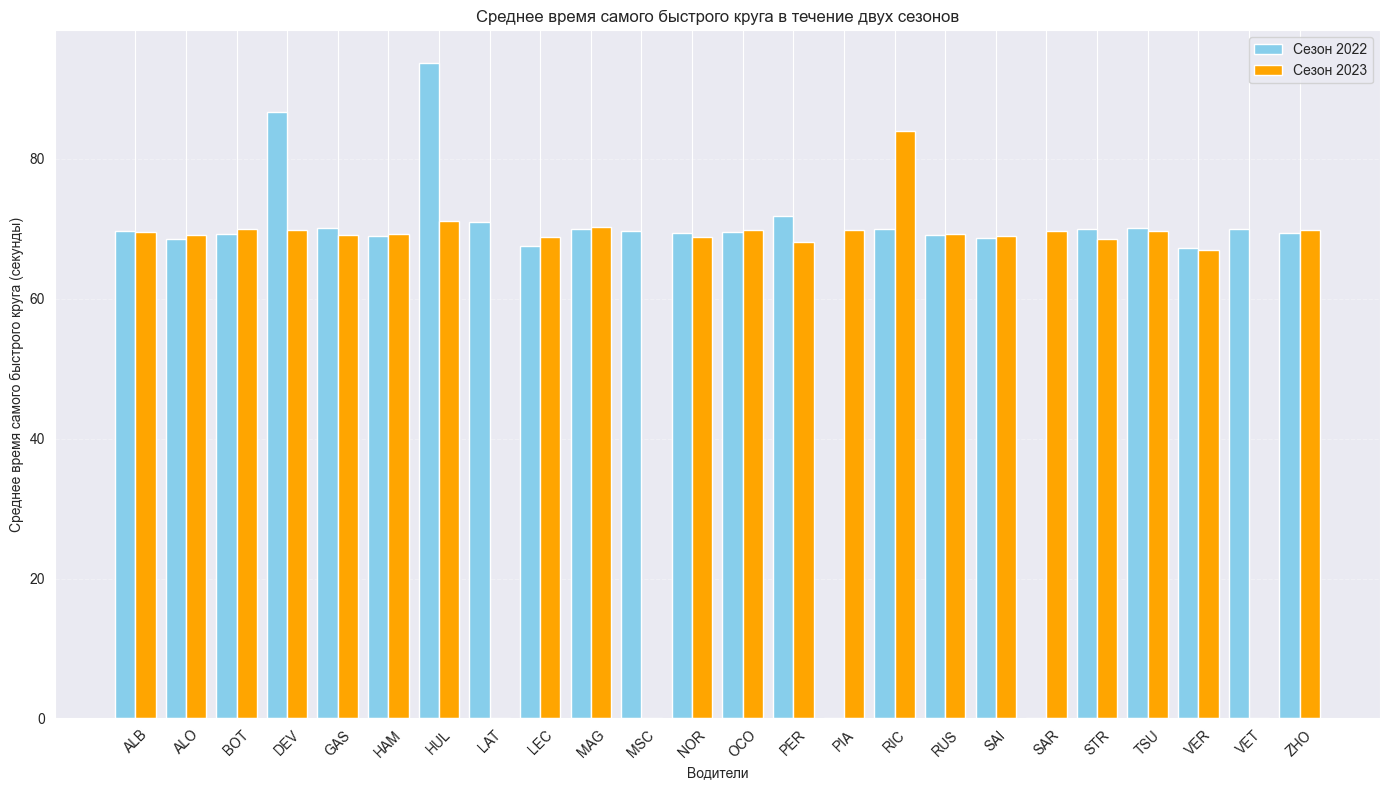

In [43]:
# Объединение df_lap с df_drivers по столбцу driverId
df_merged = pd.merge(df_lap, df_drivers, on='driverId')

# Разделение данных по сезонам
season_2022, season_2023 = seasons_separation(df_merged)

# Найдем самый быстрый круг для каждого водителя в сезонах
fastest_laps_2022 = season_2022.groupby(['driverId', 'code'])['milliseconds'].min().reset_index()
fastest_laps_2023 = season_2023.groupby(['driverId', 'code'])['milliseconds'].min().reset_index()

# Расчет средней скорости самого быстрого круга для каждого водителя в течение сезонов
average_fastest_lap_speeds_2022 = fastest_laps_2022.groupby('code')['milliseconds'].mean() / 1000  # Перевод в секунды
average_fastest_lap_speeds_2023 = fastest_laps_2023.groupby('code')['milliseconds'].mean() / 1000  # Перевод в секунды

# Создание общего списка кодов водителей
codes = sorted(set(average_fastest_lap_speeds_2022.index).union(set(average_fastest_lap_speeds_2023.index)))

# Определение ширины столбцов и смещения
bar_width = 0.4
index = np.arange(len(codes))

# Создание столбчатой диаграммы
plt.figure(figsize=(14, 8))

# Построим данные для сезона 2022
bars_2022 = plt.bar(index - bar_width/2, [average_fastest_lap_speeds_2022.get(code, 0) for code in codes], bar_width, color='skyblue', label='Сезон 2022')

# Построим данные для сезона 2023
bars_2023 = plt.bar(index + bar_width/2, [average_fastest_lap_speeds_2023.get(code, 0) for code in codes], bar_width, color='orange', label='Сезон 2023')

plt.title('Среднее время самого быстрого круга в течение двух сезонов')
plt.xlabel('Водители')
plt.ylabel('Среднее время самого быстрого круга (секунды)')
plt.xticks(index, codes, rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

#### Очки и статистика по водителям:

###### Общие очки по сезонам. График, показывающий, как каждый водитель набирал очки по сезонам

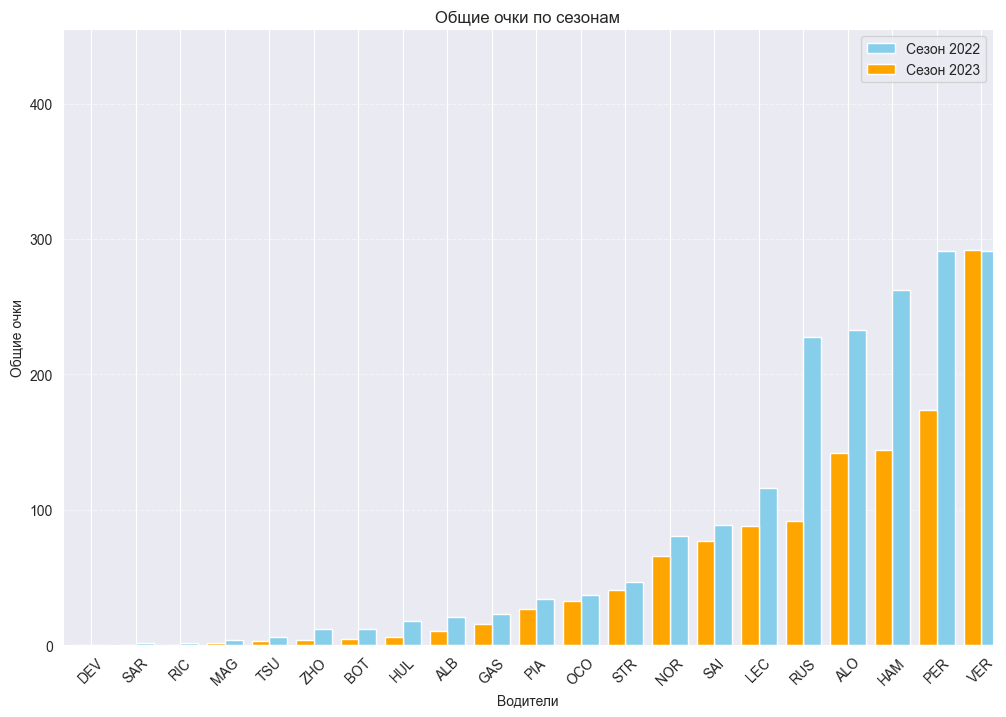

In [44]:
# Объединим df_results с df_drivers по столбцу driverId
df_merged = pd.merge(df_results, df_drivers, on='driverId')

# Разделим данные по сезонам
season_2022, season_2023 = seasons_separation(df_merged)

# Рассчет общих очков каждого водителя по сезонам
total_points_2022 = season_2022.groupby('code')['points'].sum().sort_values()
total_points_2023 = season_2023.groupby('code')['points'].sum().sort_values()

plt.figure(figsize=(12, 8))

# Создание отдельных графиков и объединение их
ax = total_points_2022.plot(kind='bar', color='skyblue', label='Сезон 2022', position=0, width=0.4)
total_points_2023.plot(kind='bar', color='orange', label='Сезон 2023', position=1, width=0.4, ax=ax)

plt.title('Общие очки по сезонам')
plt.xlabel('Водители')
plt.ylabel('Общие очки')
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

###### Тепловая карта результатов водителя, где строки – это водители, столбцы – гонки, а цвета отражают набранные очки.

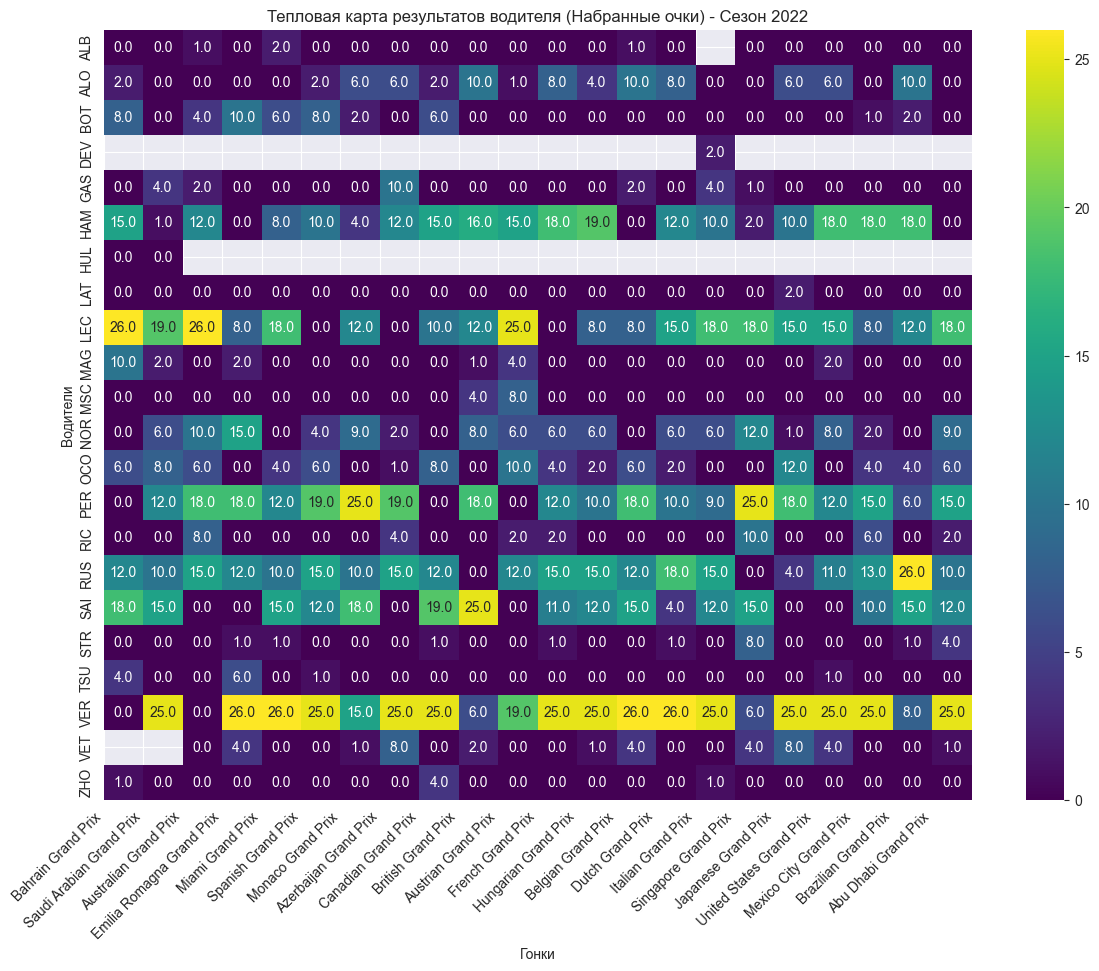

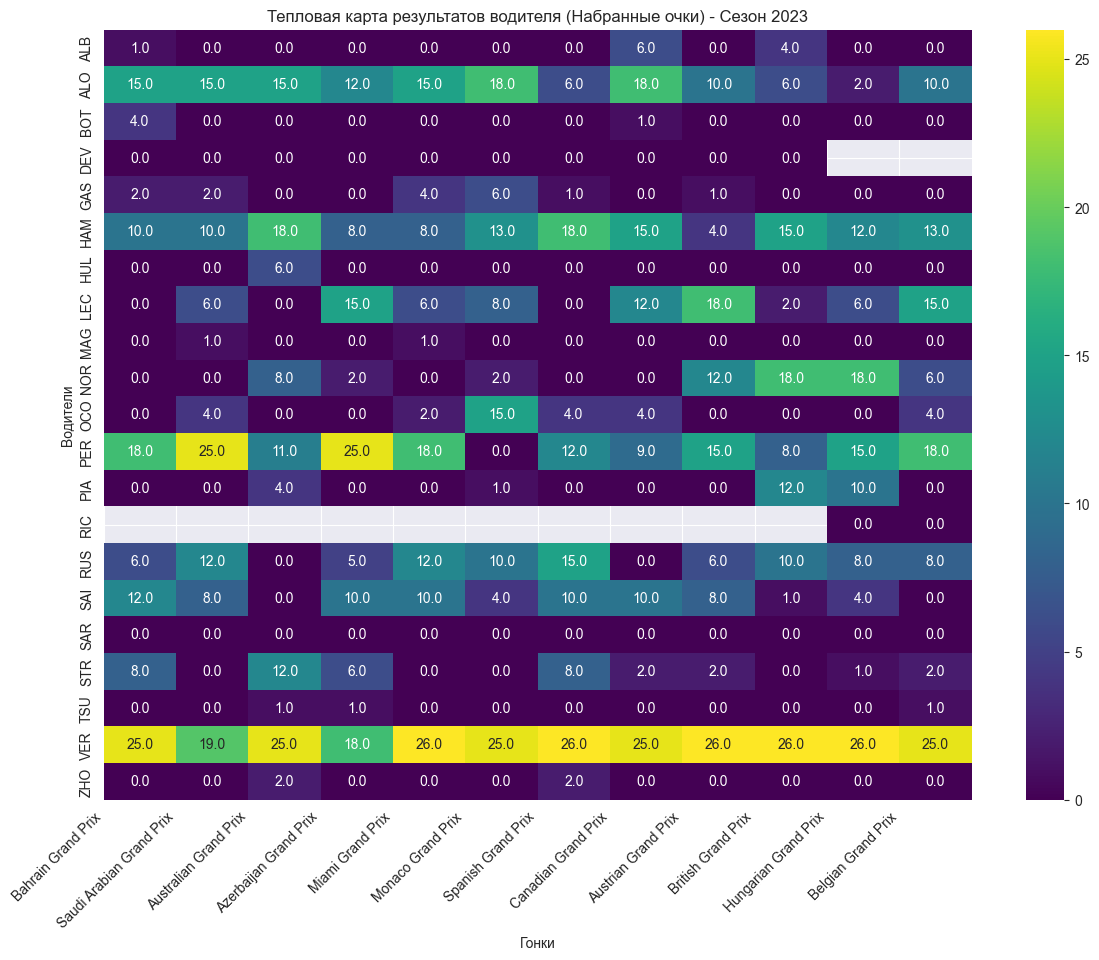

In [45]:
# Объединение df_results с df_drivers по столбцу driverId
df_merged = pd.merge(df_results, df_drivers, on='driverId')

# Разделим данные по сезонам
season_2022, season_2023 = seasons_separation(df_merged)

# Получение названий гонок из df_races
race_names = df_races.set_index('raceId')['name']

# Функция для построения тепловой карты
def plot_heatmap(pivot_table, title):
    plt.figure(figsize=(14, 10))
    sns.heatmap(pivot_table, cmap='viridis', annot=True, fmt=".1f", cbar=True)
    plt.xticks(ticks=range(len(pivot_table.columns)), labels=race_names[pivot_table.columns], rotation=45, ha='right')
    plt.title(title)
    plt.xlabel('Гонки')
    plt.ylabel('Водители')
    plt.show()

# Создание сводной таблицы набранных очков для каждого сезона
pivot_table_points_2022 = season_2022.pivot_table(index='code', columns='raceId', values='points')
pivot_table_points_2023 = season_2023.pivot_table(index='code', columns='raceId', values='points')

# Построение тепловых карт для каждого сезона
plot_heatmap(pivot_table_points_2022, 'Тепловая карта результатов водителя (Набранные очки) - Сезон 2022')
plot_heatmap(pivot_table_points_2023, 'Тепловая карта результатов водителя (Набранные очки) - Сезон 2023')

#### Сравнение команд (конструкторов):

###### График суммарных результатов команд - столбчатая диаграмма, показывающая суммарные очки каждой команды в разрезе сезонов.

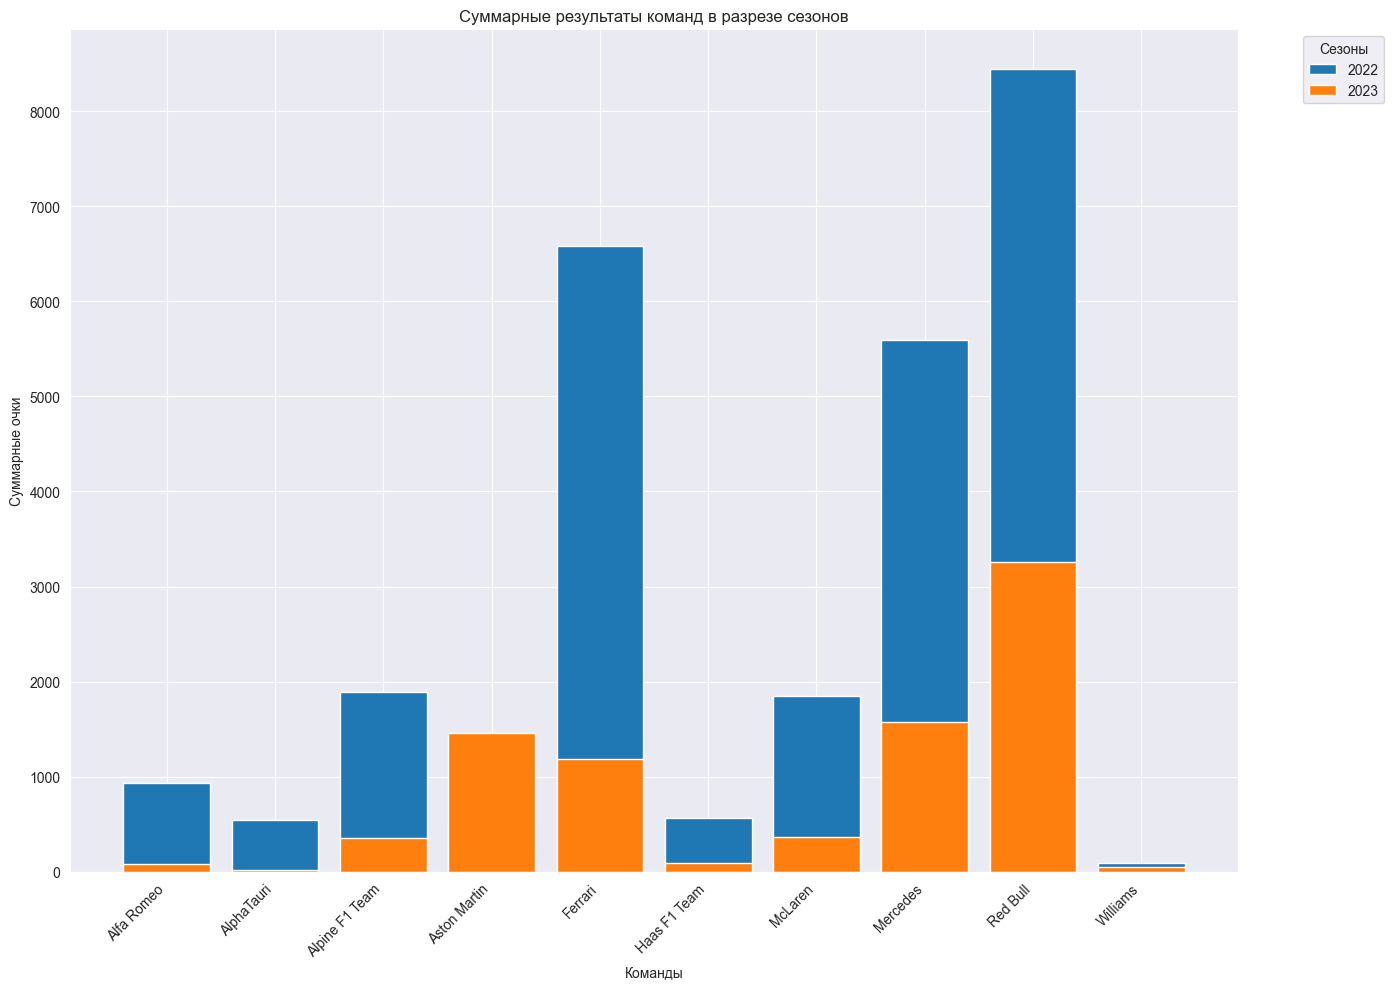

In [46]:
# Объединение df_constructor_standings с df_constructors по столбцу constructorId
df_merged_constructor = pd.merge(df_constructor_standings, df_constructors, on='constructorId')

# Разделим данные по сезонам
season_2022, season_2023 = seasons_separation(df_merged_constructor)

# Создание столбчатой диаграммы суммарных результатов команд в разрезе сезонов
plt.figure(figsize=(14, 10))

# Группировка данных по сезонам и командам и расчет суммы очков
pivot_table_2022 = season_2022.pivot_table(index='name', values='points', aggfunc='sum')
pivot_table_2023 = season_2023.pivot_table(index='name', values='points', aggfunc='sum')

# Создание столбчатой диаграммы для каждого сезона
plt.bar(pivot_table_2022.index, pivot_table_2022['points'], label='2022')
plt.bar(pivot_table_2023.index, pivot_table_2023['points'], label='2023')

plt.title('Суммарные результаты команд в разрезе сезонов')
plt.xlabel('Команды')
plt.ylabel('Суммарные очки')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Сезоны', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

###### График общих расходов по гонкам - столбчатая диаграмма, показывающая суммарные расходы на каждую гонку за сезоны 2022 и 2023.

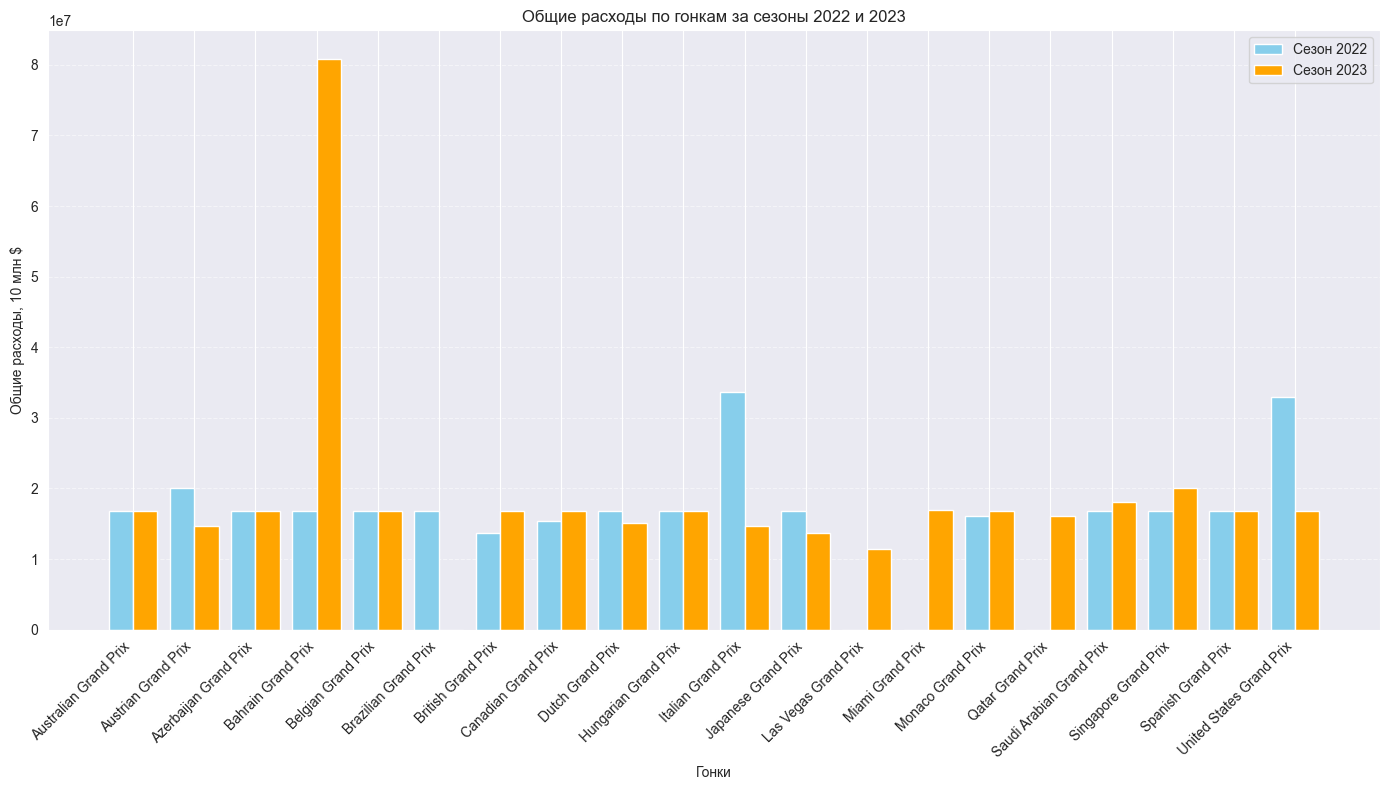

In [47]:
# Разделим данные по годам
race_spends_2022 = df_race_spends[df_race_spends['year'] == 2022]
race_spends_2023 = df_race_spends[df_race_spends['year'] == 2023]

# Суммарные расходы по гонкам для каждого сезона
total_spends_2022 = race_spends_2022.groupby('title')['sum'].sum().sort_values()
total_spends_2023 = race_spends_2023.groupby('title')['sum'].sum().sort_values()

# Создание общего списка гонок
races = sorted(set(total_spends_2022.index).union(set(total_spends_2023.index)))

# Определение ширины столбцов и смещения
bar_width = 0.4
index = np.arange(len(races))

# Создание столбчатой диаграммы
plt.figure(figsize=(14, 8))

# Построим данные для сезона 2022
bars_2022 = plt.bar(index - bar_width/2, [total_spends_2022.get(race, 0) for race in races], bar_width, color='skyblue', label='Сезон 2022')

# Построим данные для сезона 2023
bars_2023 = plt.bar(index + bar_width/2, [total_spends_2023.get(race, 0) for race in races], bar_width, color='orange', label='Сезон 2023')

plt.title('Общие расходы по гонкам за сезоны 2022 и 2023')
plt.xlabel('Гонки')
plt.ylabel('Общие расходы, 10 млн $')
plt.xticks(index, races, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

###### График зависимости трат на гонку и очков - точечные диаграммы, показывающие зависимость между расходами на гонку и полученными очками для всех команд в сезонах 2022 и 2023 с использованием логарифмической шкалы для оси X.

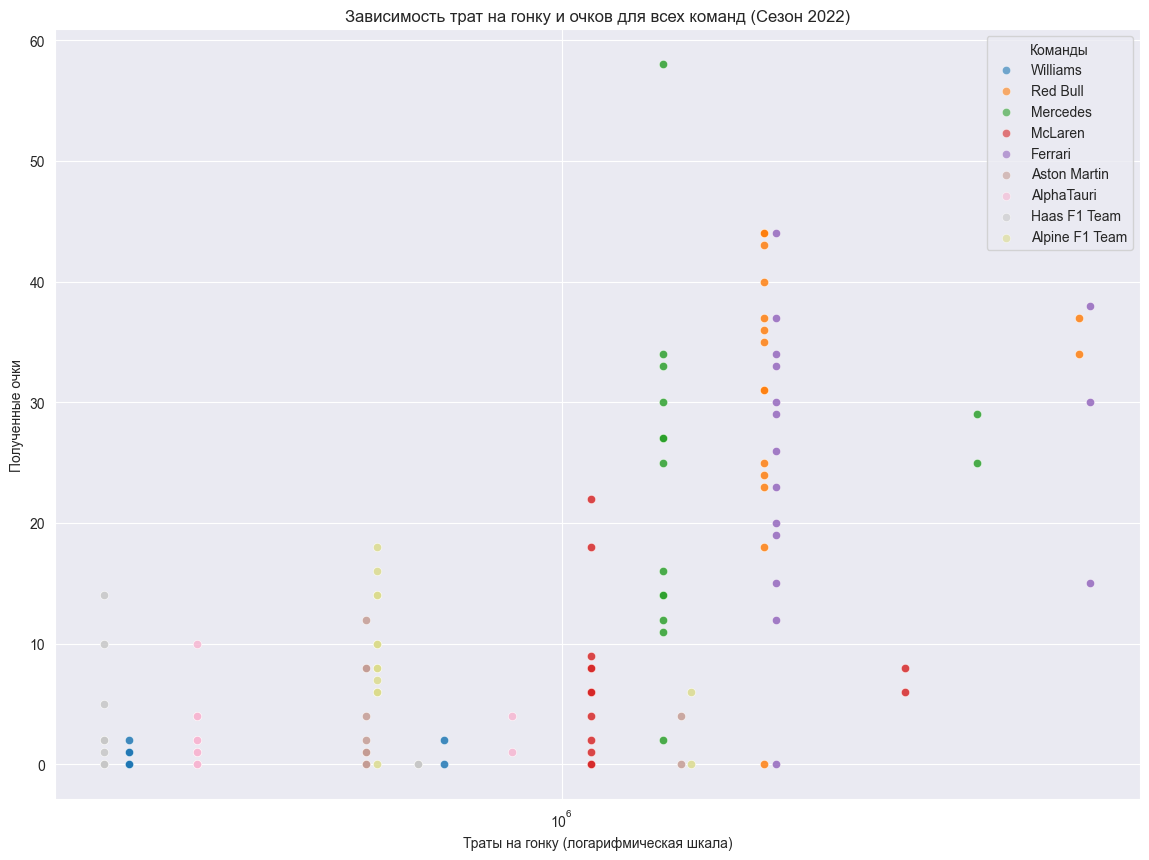

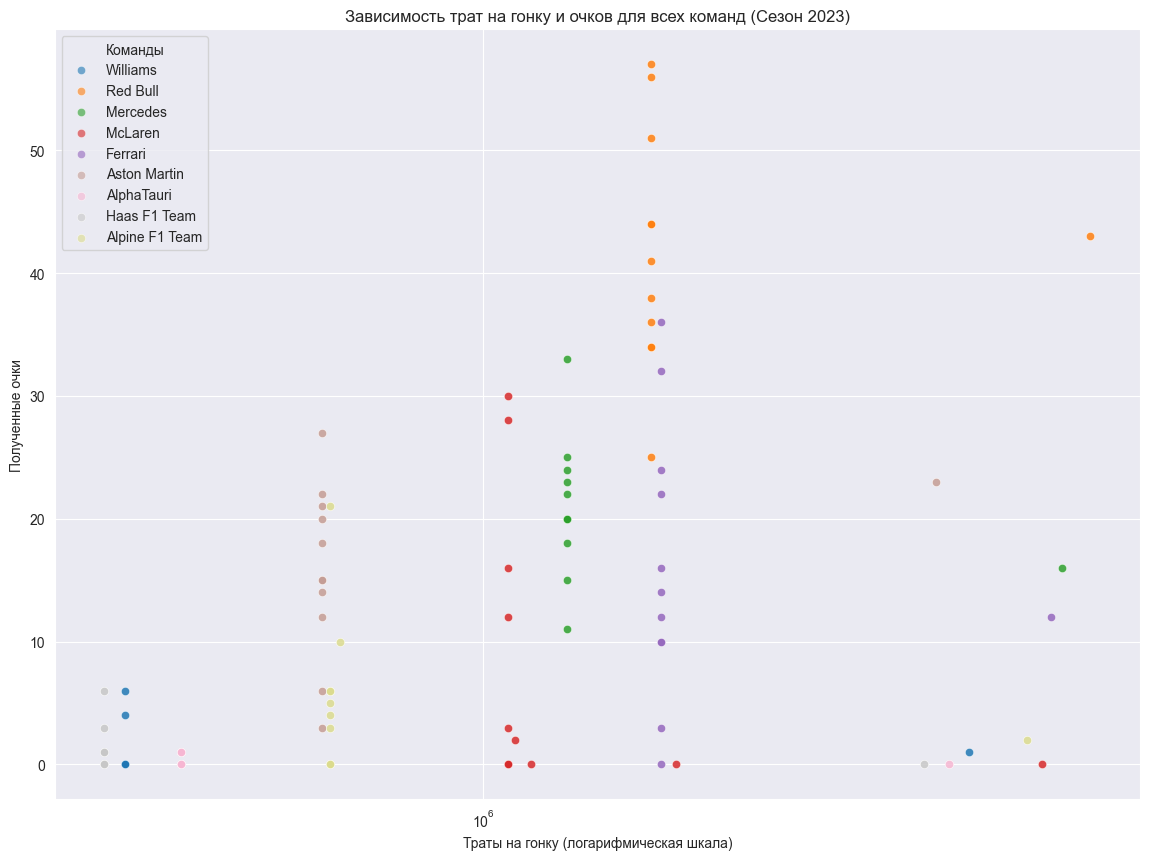

In [48]:
# Объединение df_race_spends с df_constructor_results по столбцам raceId и constructorId
df_merged = pd.merge(df_race_spends, df_constructor_results, on=['raceId', 'constructorId'])

# Объединение df_merged с df_constructors по столбцу constructorId
df_merged = pd.merge(df_merged, df_constructors, on='constructorId')

# Разделим данные по сезонам
season_2022, season_2023 = seasons_separation(df_merged)

# Получение списка команд для каждого сезона
teams_2022 = season_2022['name'].unique()
teams_2023 = season_2023['name'].unique()

# Функция для построения графика
def plot_team_spends_vs_points(season_data, teams, title):
    plt.figure(figsize=(14, 10))
    colors = plt.get_cmap('tab20')

    for i, team in enumerate(teams):
        team_data = season_data[season_data['name'] == team]
        plt.scatter(team_data['sum'], team_data['points'], alpha=0.6, edgecolor='w', linewidth=0.5, label=team, color=colors(i / len(teams)))

    plt.xscale('log')
    plt.title(title)
    plt.xlabel('Траты на гонку (логарифмическая шкала)')
    plt.ylabel('Полученные очки')
    plt.legend(title='Команды')
    plt.grid(True)
    plt.show()

# Построение графиков для сезонов 2022 и 2023
plot_team_spends_vs_points(season_2022, teams_2022, 'Зависимость трат на гонку и очков для всех команд (Сезон 2022)')
plot_team_spends_vs_points(season_2023, teams_2023, 'Зависимость трат на гонку и очков для всех команд (Сезон 2023)')

Анализ графиков показывает, что зависимость полученных очков от вложений отсутствует при рассмотрении данных отдельно по каждой команде. Это объясняется тем, что имеющиеся данные распределения бюджетов команд по гран-при не качественны. Доступные данные представляют собой бюджет команды на сезон, разделённый на количество гран-при, что не отражает точного распределения расходов.

Кроме того, в данных наблюдаются выбросы. Среди них можно выделить выбросы по бюджету, что представляют собой случаи, когда на определённые гран-при команды выделяли значительно больший бюджет по неизвестным причинам. Также присутствуют выбросы по очкам, которые проявляются в редких случаях, когда команда-аутсайдер занимает поул-позиции в гонке.

### Корреляционный анализ

In [49]:
# Объединение данных по ключевым столбцам
df_merged_results = pd.merge(df_results, df_drivers, on='driverId')
df_merged_race_spends = pd.merge(df_race_spends, df_constructor_results, on=['raceId', 'constructorId'])
df_merged_race_spends = pd.merge(df_merged_race_spends, df_constructors, on='constructorId')
df_merged_all = pd.merge(df_merged_race_spends, df_merged_results, on=['raceId', 'constructorId'])

# Выбор количественных признаков для анализа
quantitative_features = ['sum', 'points_x', 'milliseconds', 'grid', 'positionOrder']

# Проверка на наличие некорректных значений
for feature in quantitative_features:
    if feature in df_merged_all.columns:
        non_numeric_values = df_merged_all[~df_merged_all[feature].apply(lambda x: isinstance(x, (int, float)) or pd.isnull(x))]
        if not non_numeric_values.empty:
            print(f"Некорректные значения в столбце {feature}:")
            print(non_numeric_values[[feature]].drop_duplicates())

Некорректные значения в столбце milliseconds:
     milliseconds
0        10974147
1              \N
8         4834633
12        5254794
28        5826650
...           ...
1013      6594342
1020      5025169
1021      5033534
1024      5347182
1025      5351470

[352 rows x 1 columns]


В данных присутствуют значения \N, которые невозможно обработать, поэтому их стоит заменить, преобразуем все некорректные значения в NaN.

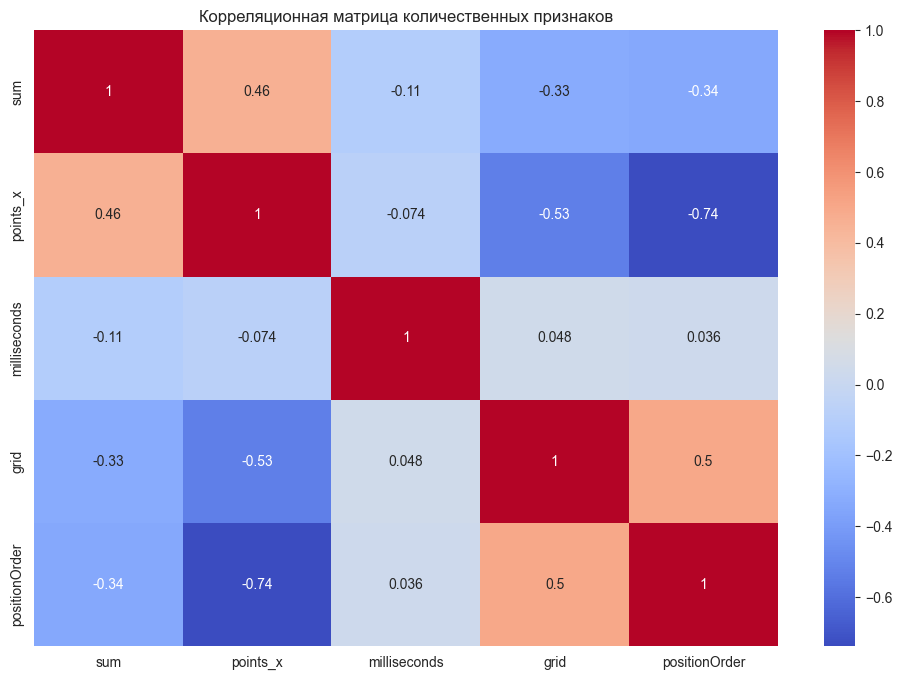

In [50]:
# Замена некорректных значений на NaN и преобразование столбцов в числовой тип
for feature in quantitative_features:
    if feature in df_merged_all.columns:
        df_merged_all[feature] = pd.to_numeric(df_merged_all[feature], errors='coerce')

# Построение корреляционной матрицы
correlation_matrix = df_merged_all[quantitative_features].corr()

# Визуализация корреляционной матрицы
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица количественных признаков')
plt.show()

points_x - это очки команд из df_constructor_results. Они будут использоваться для анализа, так как данные о бюджетах присутствуют только общекомандные.

In [51]:
df_merged_all

,id,title,sum,year,raceId,constructorId,constructorResultsId,points_x,status,constructorRef,...,fastestLapSpeed,statusId,driverRef,number_y,code,forename,surname,dob,nationality_y,url_y
0,19,Japanese Grand Prix,385417,2022,1092,3,16625,2.0,\N,williams,...,192.904,1,latifi,6,LAT,Nicholas,Latifi,1995-06-29,Canadian,http://en.wikipedia.org/wiki/Nicholas_Latifi
1,19,Japanese Grand Prix,385417,2022,1092,3,16625,2.0,\N,williams,...,\N,9,albon,23,ALB,Alexander,Albon,1996-03-23,Thai,http://en.wikipedia.org/wiki/Alexander_Albon
2,19,Japanese Grand Prix,385417,2022,1092,3,16625,2.0,\N,williams,...,192.904,1,latifi,6,LAT,Nicholas,Latifi,1995-06-29,Canadian,http://en.wikipedia.org/wiki/Nicholas_Latifi
3,19,Japanese Grand Prix,385417,2022,1092,3,16625,2.0,\N,williams,...,\N,9,albon,23,ALB,Alexander,Albon,1996-03-23,Thai,http://en.wikipedia.org/wiki/Alexander_Albon
4,8,Monaco Grand Prix,385417,2022,1080,3,16518,0.0,\N,williams,...,152.880,11,latifi,6,LAT,Nicholas,Latifi,1995-06-29,Canadian,http://en.wikipedia.org/wiki/Nicholas_Latifi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,15,Belgian Grand Prix,683000,2023,1110,214,16785,10.0,\N,alpine,...,227.339,1,gasly,10,GAS,Pierre,Gasly,1996-02-07,French,http://en.wikipedia.org/wiki/Pierre_Gasly
1024,9,Spanish Grand Prix,665000,2023,1105,214,16734,5.0,\N,alpine,...,212.362,1,ocon,31,OCO,Esteban,Ocon,1996-09-17,French,http://en.wikipedia.org/wiki/Esteban_Ocon
1025,9,Spanish Grand Prix,665000,2023,1105,214,16734,5.0,\N,alpine,...,213.910,1,gasly,10,GAS,Pierre,Gasly,1996-02-07,French,http://en.wikipedia.org/wiki/Pierre_Gasly
1026,9,Spanish Grand Prix,665000,2023,1105,214,16734,5.0,\N,alpine,...,212.362,1,ocon,31,OCO,Esteban,Ocon,1996-09-17,French,http://en.wikipedia.org/wiki/Esteban_Ocon


## Машинное обучение

На основе данных о бюджетах команд и их результатах в гонках можно сформулировать несколько интересных задач машинного обучения, но я выберу одну для анализа.

##### Прогнозирование результатов гонок:

Задача: Создать модель, которая может прогнозировать позиции, которые займут команды или водители в гонках, на основе их бюджета и предыдущих результатов.

Тип модели: Линейная регрессия

Ценность: Понять влияние финансовых ресурсов команд на их успех в гонках.

### Подготовка данных к решению задачи машинного обучения

#### Удалим дубликаты

В данных появились дубликаты, которые следовало бы отчистить. Сделать это можно по признаку 'resultId'

In [52]:
# Удаление дубликатов строк с одинаковыми значениями в столбце 'resultId'
df_merged_all = df_merged_all.drop_duplicates(subset='resultId')

df_merged_all

,id,title,sum,year,raceId,constructorId,constructorResultsId,points_x,status,constructorRef,...,fastestLapSpeed,statusId,driverRef,number_y,code,forename,surname,dob,nationality_y,url_y
0,19,Japanese Grand Prix,385417,2022,1092,3,16625,2.0,\N,williams,...,192.904,1,latifi,6,LAT,Nicholas,Latifi,1995-06-29,Canadian,http://en.wikipedia.org/wiki/Nicholas_Latifi
1,19,Japanese Grand Prix,385417,2022,1092,3,16625,2.0,\N,williams,...,\N,9,albon,23,ALB,Alexander,Albon,1996-03-23,Thai,http://en.wikipedia.org/wiki/Alexander_Albon
4,8,Monaco Grand Prix,385417,2022,1080,3,16518,0.0,\N,williams,...,152.880,11,latifi,6,LAT,Nicholas,Latifi,1995-06-29,Canadian,http://en.wikipedia.org/wiki/Nicholas_Latifi
5,8,Monaco Grand Prix,385417,2022,1080,3,16518,0.0,\N,williams,...,153.969,26,albon,23,ALB,Alexander,Albon,1996-03-23,Thai,http://en.wikipedia.org/wiki/Alexander_Albon
8,17,Italian Grand Prix,770834,2022,1089,3,16605,2.0,\N,williams,...,240.750,1,de_vries,21,DEV,Nyck,de Vries,1995-02-06,Dutch,http://en.wikipedia.org/wiki/Nyck_de_Vries
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,12,British Grand Prix,665000,2023,1108,214,16769,0.0,\N,alpine,...,225.754,44,ocon,31,OCO,Esteban,Ocon,1996-09-17,French,http://en.wikipedia.org/wiki/Esteban_Ocon
1020,15,Belgian Grand Prix,683000,2023,1110,214,16785,10.0,\N,alpine,...,228.310,1,ocon,31,OCO,Esteban,Ocon,1996-09-17,French,http://en.wikipedia.org/wiki/Esteban_Ocon
1021,15,Belgian Grand Prix,683000,2023,1110,214,16785,10.0,\N,alpine,...,227.339,1,gasly,10,GAS,Pierre,Gasly,1996-02-07,French,http://en.wikipedia.org/wiki/Pierre_Gasly
1024,9,Spanish Grand Prix,665000,2023,1105,214,16734,5.0,\N,alpine,...,212.362,1,ocon,31,OCO,Esteban,Ocon,1996-09-17,French,http://en.wikipedia.org/wiki/Esteban_Ocon


#### Удалим из данных ненужные для анализа признаки

In [53]:
# Список столбцов, которые необходимо удалить
columns_to_delete = ['nationality_x', 'url_x', 'driverRef', 'forename', 'surname', 'nationality_y', 'url_y']

# Удаление ненужных столбцов
df_merged_all = df_merged_all.drop(columns_to_delete, axis=1)

#### Создание новых признаков 

###### Логарифмирование бюджета

Так как бюджеты могут иметь широкий диапазон значений, можно использовать логарифмирование для уменьшения размаха данных.

In [54]:
df_merged_all['log_sum'] = np.log1p(df_merged_all['sum'])

df_merged_all

,id,title,sum,year,raceId,constructorId,constructorResultsId,points_x,status,constructorRef,...,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,number_y,code,dob,log_sum
0,19,Japanese Grand Prix,385417,2022,1092,3,16625,2.0,\N,williams,...,10974147.0,12,18,1:48.371,192.904,1,6,LAT,1995-06-29,12.862084
1,19,Japanese Grand Prix,385417,2022,1092,3,16625,2.0,\N,williams,...,NaN,\N,0,\N,\N,9,23,ALB,1996-03-23,12.862084
4,8,Monaco Grand Prix,385417,2022,1080,3,16518,0.0,\N,williams,...,NaN,43,18,1:18.579,152.880,11,6,LAT,1995-06-29,12.862084
5,8,Monaco Grand Prix,385417,2022,1080,3,16518,0.0,\N,williams,...,NaN,40,16,1:18.023,153.969,26,23,ALB,1996-03-23,12.862084
8,17,Italian Grand Prix,770834,2022,1089,3,16605,2.0,\N,williams,...,4834633.0,41,13,1:26.624,240.750,1,21,DEV,1995-02-06,13.555230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,12,British Grand Prix,665000,2023,1108,214,16769,0.0,\N,alpine,...,NaN,4,20,1:33.941,225.754,44,31,OCO,1996-09-17,13.407544
1020,15,Belgian Grand Prix,683000,2023,1110,214,16785,10.0,\N,alpine,...,5025169.0,27,8,1:50.439,228.310,1,31,OCO,1996-09-17,13.434252
1021,15,Belgian Grand Prix,683000,2023,1110,214,16785,10.0,\N,alpine,...,5033534.0,25,12,1:50.911,227.339,1,10,GAS,1996-02-07,13.434252
1024,9,Spanish Grand Prix,665000,2023,1105,214,16734,5.0,\N,alpine,...,5347182.0,54,18,1:18.946,212.362,1,31,OCO,1996-09-17,13.407544


#### Создание признаков на основе предыдущих результатов

**Средние очки за последние 3 гонки**:
   Этот признак отражает текущую форму команды, показывая, как стабильно она набирает очки в последних гонках.
   
**Средние очки за последние 5 гонок**:
   Этот признак сглаживает краткосрочные колебания и помогает оценить производительность команды на средней дистанции.
   
**Средние очки за последние 10 гонок**:
   Этот признак дает долгосрочный обзор эффективности команды, учитывая большее количество гонок для более стабильного показателя.

In [55]:
# Средние очки за последние 3, 5 и 10 гонок
df_merged_all['avg_points_last_3'] = df_merged_all.groupby('constructorId')['points_x'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
df_merged_all['avg_points_last_5'] = df_merged_all.groupby('constructorId')['points_x'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
df_merged_all['avg_points_last_10'] = df_merged_all.groupby('constructorId')['points_x'].transform(lambda x: x.rolling(window=10, min_periods=1).mean())

**Дельта между стартовой и финишной позицией**:
   Этот признак показывает способность команды улучшать свою позицию во время гонки, что может указывать на стратегические и тактические преимущества.

In [56]:
# Дельта между стартовой и финишной позицией
df_merged_all['position_delta'] = df_merged_all['grid'] - df_merged_all['positionOrder']

**Суммарные расходы команды за сезон**:
   Этот признак отображает накопленные расходы команды на текущий сезон, что может коррелировать с ее общей конкурентоспособностью.

In [57]:
# Суммарные расходы команды за сезон
df_merged_all['cumulative_spends'] = df_merged_all.groupby(['constructorId', 'year'])['sum'].cumsum()

**Количество гонок в сезоне**:
   Этот признак указывает на опыт команды в текущем сезоне, что может влиять на ее стратегические решения и производительность.

In [58]:
# Количество гонок в сезоне
df_merged_all['race_count_season'] = df_merged_all.groupby(['constructorId', 'year']).cumcount() + 1

**Среднее время круга**:
   Этот признак отражает технические возможности команды и скорость автомобиля, что напрямую влияет на результаты гонок.

In [59]:
# Среднее время круга (если данные доступны)
df_merged_all['avg_lap_time'] = df_merged_all.groupby(['constructorId', 'raceId'])['milliseconds'].transform('mean')

**One-Hot Encoding для категориальных признаков**
    Преобразуем OHE-кодированием названия команд в числовой формат. Это улучшает качество модели, обеспечит правильную обработку данных.

In [60]:
df_merged_all = pd.get_dummies(df_merged_all, columns=['constructorRef', 'year'])

df_merged_all

,id,title,sum,raceId,constructorId,constructorResultsId,points_x,status,name,resultId,...,constructorRef_alpine,constructorRef_aston_martin,constructorRef_ferrari,constructorRef_haas,constructorRef_mclaren,constructorRef_mercedes,constructorRef_red_bull,constructorRef_williams,year_2022,year_2023
0,19,Japanese Grand Prix,385417,1092,3,16625,2.0,\N,Williams,25754,...,False,False,False,False,False,False,False,True,True,False
1,19,Japanese Grand Prix,385417,1092,3,16625,2.0,\N,Williams,25765,...,False,False,False,False,False,False,False,True,True,False
4,8,Monaco Grand Prix,385417,1080,3,16518,0.0,\N,Williams,25540,...,False,False,False,False,False,False,False,True,True,False
5,8,Monaco Grand Prix,385417,1080,3,16518,0.0,\N,Williams,25543,...,False,False,False,False,False,False,False,True,True,False
8,17,Italian Grand Prix,770834,1089,3,16605,2.0,\N,Williams,25714,...,False,False,False,False,False,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,12,British Grand Prix,665000,1108,214,16769,0.0,\N,Alpine F1 Team,26045,...,True,False,False,False,False,False,False,False,False,True
1020,15,Belgian Grand Prix,683000,1110,214,16785,10.0,\N,Alpine F1 Team,26073,...,True,False,False,False,False,False,False,False,False,True
1021,15,Belgian Grand Prix,683000,1110,214,16785,10.0,\N,Alpine F1 Team,26076,...,True,False,False,False,False,False,False,False,False,True
1024,9,Spanish Grand Prix,665000,1105,214,16734,5.0,\N,Alpine F1 Team,25973,...,True,False,False,False,False,False,False,False,False,True


#### Масштабирование данных
###### **Стандартизация признаков**

Применим стандартизацию (нормализацию) к количественным признакам для улучшения качества модели.

In [61]:
# Выбор количественных признаков для анализа
quantitative_features = ['log_sum', 'avg_points_last_3', 'avg_points_last_5', 'avg_points_last_10', 'position_delta', 'cumulative_spends', 'race_count_season', 'avg_lap_time', 'grid', 'positionOrder', 'milliseconds']

# Масштабирование количественных признаков
scaler = StandardScaler()

df_merged_all[quantitative_features] = scaler.fit_transform(df_merged_all[quantitative_features])

Масштабирование данных необходимо для приведения количественных признаков к одному масштабу, что позволяет избежать доминирования признаков с большими значениями над другими в модели.

In [62]:
df_merged_all

,id,title,sum,raceId,constructorId,constructorResultsId,points_x,status,name,resultId,...,constructorRef_alpine,constructorRef_aston_martin,constructorRef_ferrari,constructorRef_haas,constructorRef_mclaren,constructorRef_mercedes,constructorRef_red_bull,constructorRef_williams,year_2022,year_2023
0,19,Japanese Grand Prix,385417,1092,3,16625,2.0,\N,Williams,25754,...,False,False,False,False,False,False,False,True,True,False
1,19,Japanese Grand Prix,385417,1092,3,16625,2.0,\N,Williams,25765,...,False,False,False,False,False,False,False,True,True,False
4,8,Monaco Grand Prix,385417,1080,3,16518,0.0,\N,Williams,25540,...,False,False,False,False,False,False,False,True,True,False
5,8,Monaco Grand Prix,385417,1080,3,16518,0.0,\N,Williams,25543,...,False,False,False,False,False,False,False,True,True,False
8,17,Italian Grand Prix,770834,1089,3,16605,2.0,\N,Williams,25714,...,False,False,False,False,False,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,12,British Grand Prix,665000,1108,214,16769,0.0,\N,Alpine F1 Team,26045,...,True,False,False,False,False,False,False,False,False,True
1020,15,Belgian Grand Prix,683000,1110,214,16785,10.0,\N,Alpine F1 Team,26073,...,True,False,False,False,False,False,False,False,False,True
1021,15,Belgian Grand Prix,683000,1110,214,16785,10.0,\N,Alpine F1 Team,26076,...,True,False,False,False,False,False,False,False,False,True
1024,9,Spanish Grand Prix,665000,1105,214,16734,5.0,\N,Alpine F1 Team,25973,...,True,False,False,False,False,False,False,False,False,True


#### Обновим корреляционную матрицу, учитывая новые признаки

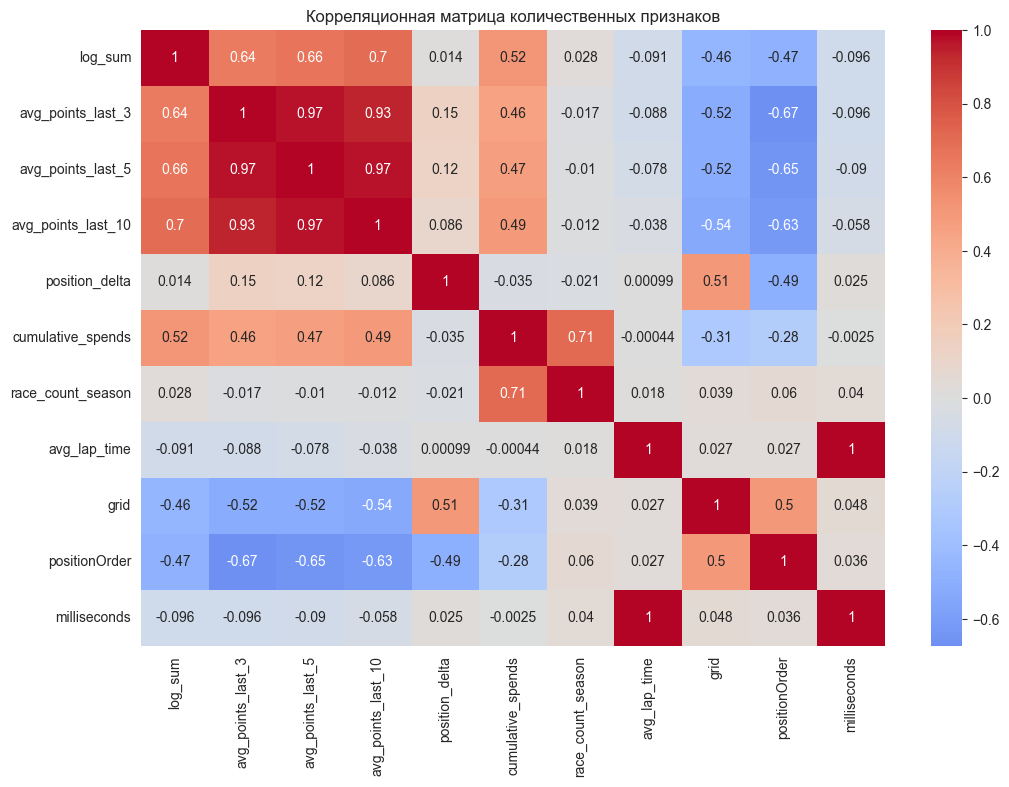

In [63]:
# Построение корреляционной матрицы
correlation_matrix = df_merged_all[quantitative_features].corr()

# Визуализация корреляционной матрицы
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляционная матрица количественных признаков')
plt.show()

### Интерпретация корреляционной матрицы

1. **log_sum** (логарифмированный бюджет) имеет положительную корреляцию с 'avg_points_last_3' (0.64), 'avg_points_last_5' (0.66) и 'avg_points_last_10' (0.7), что указывает на то, что больший бюджет может быть связан с лучшими результатами в последних гонках.


2. **position_delta** (разница между стартовой и финишной позицией) имеет заметную положительную корреляцию с 'grid' (0.51), что означает, что команды, стартующие с низших позиций, чаще улучшают свои результаты.
3. **grid** (стартовая позиция) имеет отрицательную корреляцию с 'log_sum' (-0.46), 'avg_points_last_3' (-0.52), и 'avg_points_last_5' (-0.52), что указывает на то, что команды с лучшими стартовыми позициями имеют тенденцию к лучшим результатам.

Факторы: бюджет и накопленные расходы - имеют значимое влияние на результаты гонок. Стартовая позиция и улучшение позиций также играют важную роль.

## Разделим данные на обучающую и тестовую выборки

###### В качестве целевой переменной выберем финишную позицию гонщиков на каждом гран-при,так как она напрямую указывает на результат команды в гонке. В качестве количественных признаков будем использовать только данные о бюджетах команд, количестве проведенных гонок и времени лучших кругов.

Другие переменные, такие как названия команд, позиции гонщиков на старте и среднее количество полученных очков за различные периоды, будут исключены из рассмотрения. Это связано с тем, что использование этих переменных может привести к чрезмерной очевидности зависимости и, как следствие, к чрезмерно высокой точности модели в предсказании результатов гонок. Проверка показала, что включение этих переменных обеспечивает почти 100% точность предсказаний (R2 был равен 0.96, а MSE 0.04), что не является целью построения модели.

In [83]:
# Выбор признаков
quantitative_features = ['log_sum', 'cumulative_spends', 'race_count_season', 'avg_lap_time', 'milliseconds']

# Определим целевую переменную
target = 'positionOrder'

# Разделение данных на обучающую и тестовую выборки
X = df_merged_all[quantitative_features]
y = df_merged_all[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Данные разделили, теперь можно провести обучение модели Линейной регрессии

In [84]:
# Обучение модели Линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Так как в данных присутствуют пропущенные значения (которые нечем заменить и удалять эти строки не стоит), можно воспользоваться советом питона и воспользоваться другой моделью машинного обучения, которая может обрабатывать NaN-значения. 

In [85]:
# Обучение модели
model = HistGradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)

HistGradientBoostingRegressor(random_state=42)

In [86]:
# Прогнозирование и оценка модели
y_pred = model.predict(X_test)
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'R2: {r2_score(y_test, y_pred)}')

MSE: 0.22605170105527309
R2: 0.7654577534450462


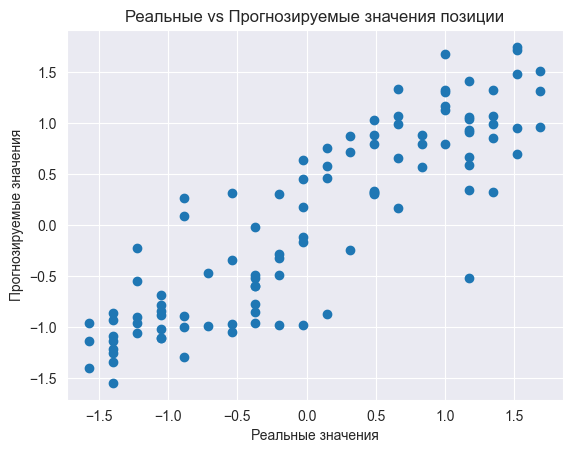

In [87]:
# Визуализация результатов
plt.scatter(y_test, y_pred)
plt.xlabel('Реальные значения')
plt.ylabel('Прогнозируемые значения')
plt.title('Реальные vs Прогнозируемые значения позиции')
plt.show()

### Интерпретация результатов

**MSE**:
- **Значение**: 0.2261
- **Интерпретация**: Значение MSE указывает на то, что ошибка прогнозирования модели выше по сравнению с предыдущим значением 0.04 (которое было при большей выборке признаков), но все еще приемлема.

**R-квадрат**:
- **Значение**: 0.7655
- **Интерпретация**: В данном случае, значение R2 означает, что 76.5% дисперсии в целевой переменной (позиции команд) объясняется признаками в модели. Это указывает на то, что модель объясняет значительную часть дисперсии, но есть еще пространство для улучшения.

Комбинация значения MSE = 0.2261 и R² = 0.7655 показывает, что модель имеет достаточно хорошую точность.

## Гипотезы

Можно сформулировать несколько гипотез, которые модель машинного обучения поможет подтвердить или опровергнуть.

##### Гипотеза о влиянии бюджета на результаты:

Формулировка: Больший бюджет команды коррелирует с лучшими результатами в гонках.

Цель проверки: Определить, существует ли статистически значимая связь между размером бюджета команды и их местами на финише.

In [99]:
# Корреляционный анализ
corr, p_value = pearsonr(df_merged_all['log_sum'], df_merged_all['positionOrder'])
print(f"Значение коэффициента корреляции Пирсона: {corr}")
print(f"P-value: {p_value}")

Значение коэффициента корреляции Пирсона: -0.47442743755524114
P-value: 3.293214139781331e-30


### Интерпретация результатов

**Pearson correlation coefficient (коэффициент корреляции Пирсона)**:
- **Значение**: -0.4744
- **Интерпретация**: Значение коэффициента указывает на умеренную отрицательную корреляцию между логарифмом бюджета команды ('log_sum') и их финишной позицией ('positionOrder'). Это означает, что по мере увеличения бюджета команды финишная позиция, как правило, улучшается (позиция становится ниже, что лучше, так как 1-е место лучше, чем 2-е и т.д.).

**P-value (p-значение)**:
- **Значение**: 3.293214139781331e-30
- **Интерпретация**: P-value показывает вероятность того, что наблюдаемая корреляция произошла случайно. Очень маленькое значение p-value указывает на то, что вероятность случайного происхождения такой корреляции крайне мала. Он значительно меньше обычного порогового значения 0.05, что говорит о явной статистической значимости корреляции.

### Вывод

Результаты корреляционного анализа показывают, что существует статистически значимая умеренная отрицательная корреляция между бюджетом команды и их финишной позицией в гонках. Это подтверждает гипотезу о том, что больший бюджет команды коррелирует с лучшими результатами в гонках. 

##### Гипотеза о важности предыдущих результатов:

Формулировка: Предыдущие результаты команды являются хорошим предиктором их будущих достижений.

Цель проверки: Проверить, насколько предыдущие достижения влияют на результаты последующих гонок.

In [108]:
# Корреляционный анализ
corr_avg_points_last_3, p_value_avg_points_last_3 = pearsonr(df_merged_all['avg_points_last_3'], df_merged_all['positionOrder'])
corr_avg_points_last_5, p_value_avg_points_last_5 = pearsonr(df_merged_all['avg_points_last_5'], df_merged_all['positionOrder'])
corr_avg_points_last_10, p_value_avg_points_last_10 = pearsonr(df_merged_all['avg_points_last_10'], df_merged_all['positionOrder'])

print(f"\n avg_points_last_3: \n Коэффициент корреляции Пирсона: {corr_avg_points_last_3} \n P-value: {p_value_avg_points_last_3} \n\n avg_points_last_5: \n Коэффициент корреляции Пирсона: {corr_avg_points_last_5} \n P-value: {p_value_avg_points_last_5} \n\n avg_points_last_10: \n Коэффициент корреляции Пирсона: {corr_avg_points_last_10} \n P-value: {p_value_avg_points_last_10}")


 avg_points_last_3: 
 Коэффициент корреляции Пирсона: -0.6740100344107149 
 P-value: 2.3975271019040415e-69 

 avg_points_last_5: 
 Коэффициент корреляции Пирсона: -0.6485402796772913 
 P-value: 1.1366612670871943e-62 

 avg_points_last_10: 
 Коэффициент корреляции Пирсона: -0.6271462618004833 
 P-value: 1.5399075238109361e-57


### Интерпретация результатов

**avg_points_last_3**:
- **Коэффициент корреляции Пирсона**: -0.6740
- **P-value**: 2.3975271019040415e-69
- **Интерпретация**: Коэффициент корреляции Пирсона -0.6740 указывает на сильную отрицательную корреляцию между средними очками за последние 3 гонки и финишной позицией. Это означает, что более высокие средние очки за последние 3 гонки связаны с лучшими финишными позициями. Очень низкое p-value подтверждает статистическую значимость этой зависимости, указывая на то, что такая корреляция вряд ли произошла случайно.

**avg_points_last_5**:
- **Коэффициент корреляции Пирсона**: -0.6485
- **P-value**: 1.1366612670871943e-62
- **Интерпретация**: Коэффициент корреляции Пирсона -0.6485 указывает на сильную отрицательную корреляцию между средними очками за последние 5 гонок и финишной позицией. Это свидетельствует о том, что команды с более высокими средними очками за последние 5 гонок имеют тенденцию занимать лучшие места в гонках. Очень низкое p-value подтверждает, что эта связь статистически значима.

**avg_points_last_10**:
- **Коэффициент корреляции Пирсона**: -0.6271
- **P-value**: 1.5399075238109361e-57
- **Интерпретация**: Коэффициент корреляции Пирсона -0.6271 указывает на сильную отрицательную корреляцию между средними очками за последние 10 гонок и финишной позицией. Это показывает, что команды с высокими средними очками за последние 10 гонок, как правило, финишируют на более высоких позициях. Очень низкое p-value указывает на статистическую значимость этой корреляции.

### Общий вывод

Все три коэффициента корреляции Пирсона показывают сильную отрицательную корреляцию между предыдущими результатами команды (средними очками за последние 3, 5 и 10 гонок) и их финишной позицией. Это подтверждает гипотезу о том, что предыдущие результаты команды являются хорошим предиктором их будущих достижений. Очень низкие значения p-value для всех трех корреляций указывают на высокую статистическую значимость этих зависимостей, что делает их практически значимыми для прогнозирования будущих результатов на основе предыдущих достижений.